In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import randn

/home/sultan/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
data = pd.read_csv('data/prices.txt')

In [4]:
data.head()

,area,rooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


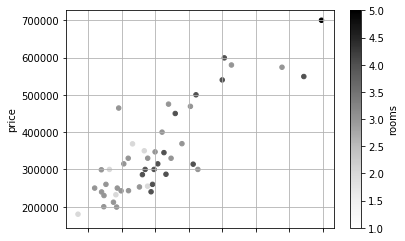

In [5]:
plot1 = data.plot(kind='scatter', x='area', y='price', c='rooms', grid=True)
#plot1.set_facecolor("gray")

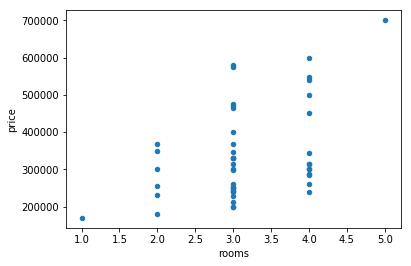

In [6]:
data.plot(kind = 'scatter', x = 'rooms', y='price')

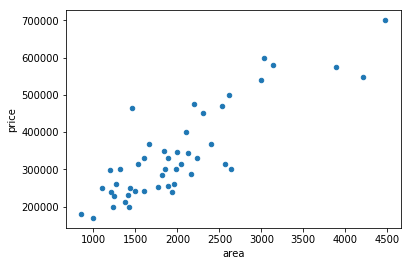

In [7]:
data.plot(kind = 'scatter', x = 'area', y='price')

In [50]:
X = data[['area', 'rooms']]
y = np.array(list(map(float, data['price'])))
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.reshape(len(y), 1)).reshape(len(y))
X = np.append(np.ones(len(X)).reshape((len(X), 1)), X, axis=1)

/home/sultan/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


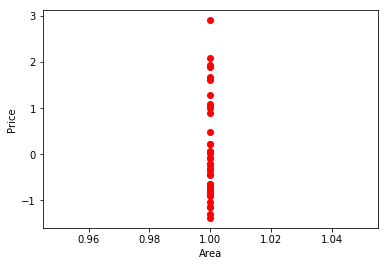

In [51]:
plt.xlabel("Area")
plt.ylabel("Price")
plt.plot(X[:, 0], y, 'ro')
plt.legend(loc = 0)

In [52]:
def get_mse(regressor, xs, ys):    
    predicted = np.apply_along_axis(regressor.predict, 1, xs)
    return ((predicted - ys) ** 2).mean()
    
def kf_cross_validation(regressor, xs, ys, n_fold=10, times=1, **params):
    res = 0
    for _ in range(times):
        kf = KFold(len(xs), n_fold, True, 0)
        kf_sum = 0
        fold_num = 0
        for train_i, test_i in kf:
            regressor.fit(xs[train_i], ys[train_i])
            meas = get_mse(regressor, xs[test_i], ys[test_i])
            fold_num += 1
            kf_sum += meas
            print("Time {}, fold {} done, error = {}".format(_, fold_num, meas))
        res += kf_sum/n_fold
    return res/times

In [53]:
class LinearRegression:
    def __init__(self, w = None, linearCoef = 0.5, numIter = 100):
        self.baseW = w
        self.linearCoef = linearCoef   
        self.numIter = numIter
        
    def _grad_descend(self):
        Xt = X.transpose()
        m = X.shape[0]
        mse = None
        w = self.baseW
        for i in range(self.numIter):
            h = np.dot(X, w)
            diff = h - y
            grad = np.dot(Xt, diff) / m
            mse = np.sum(diff ** 2) / (2 * m)
            w -= (self.linearCoef[i] * grad)
            
        self.w = w      
    
    def fit(self, X, y):
        self.X = X
        self.y = y      
        self._grad_descend()

    def predict(self, X):               
        return np.dot(X, self.w)
    
    def weights(self):
        return self.w


In [54]:
X_learn, X_holdout, y_learn, y_holdout = train_test_split(X, y, test_size=0.1, random_state=1)
#X_train, X_test, y_train, y_test       = train_test_split(X_learn, y_learn, test_size=0.33, random_state=1)

In [55]:
print("Learn size: %d" % X_learn.shape[0])
print("Hold-out size: %d" % X_holdout.shape[0])

Learn size: 42
Hold-out size: 5


In [56]:
m, n = X.shape
w = np.ones(n)
numIter = 1000
linearCoef = [0.1] * numIter
linearReg = LinearRegression(w = w, linearCoef = linearCoef, numIter = numIter)
#print (kf_cross_validation(linearReg, X_learn, y_learn))
linearReg.fit(X, y)
print (get_mse(linearReg, X, y))
print (linearReg.weights())

0.267054981971
[ -8.42710394e-17   8.84765988e-01  -5.31788197e-02]


In [65]:
np.random.seed(53)

def mutation(pop):
    return pop + randn(*pop.shape)

class GeneticReg:
    def __init__(self, numIter = 100, popSize = 10, mutationCount = 5):        
        self.numIter = numIter
        self.popSize = popSize
        self.mutationCout = mutationCount
    
    def gen_optimize(self):
        m, n = self.X.shape
        pop = np.zeros((self.popSize, n))
        pops = []
        mses = []
        #print (pop)
       
        for i in range(numIter):
            pops = pop.copy()
            for j in range(self.mutationCount):
                pops = np.append(pops, mutation(pop), axis=0)
            
            #print (pops)
            mses = []
            for j, single_pop in enumerate(pops):
                h = np.dot(X, single_pop)
                diff = h - y
                mse = np.sum(diff ** 2) / (2 * m)
                mses.append((mse, j))
            mses = sorted(mses)
            pop = pops[mses[0][1]].reshape(1, len(pops[mses[0][1]]))
            for _, j in mses[1:self.popSize]:
                pop = np.append(pop, pops[j].reshape(1, len(pops[j])), axis=0)            
            #print (pop)
            #print ("BIG BOY")
        
        self.w = pops[mses[0][1]]
    
    def fit(self, X, y):
        self.X = X
        self.y = y      
        self.gen_optimize()

    def predict(self, X):               
        return np.dot(X, self.w)
    
    def weights(self):
        return self.w

In [68]:
genReg = GeneticReg()
genReg.fit(X, y)
print (get_mse(genReg, X, y))
print (genReg.weights())

0.268864595987
[ 0.02444245  0.86719729 -0.01171332]
